**Autoencoders are an unsupervised learning technique which leverages neural network for the task of representation learning. This is done by imposing a bottleneck in the network which forces a compressed knowledge representation of the original input. The targets are derived from the input data. Below we develop a convolution autoencoder for image denoising. Also, the learned encoder is used further to train digit classifier. We are using MNIST digit dataset.**

In [1]:
#load the datset
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("Train images shape: {}".format(x_train.shape))
print("Test images shape: {}".format(x_test.shape))
print("Train labels shape: {}".format(y_train.shape))
print("Test labels shape: {}".format(y_test.shape))

Train images shape: (60000, 28, 28)
Test images shape: (10000, 28, 28)
Train labels shape: (60000,)
Test labels shape: (10000,)


In [2]:
#Normalize the dataset and add dummy dimension for channel as a requirement for keras conv layer
import numpy as np

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train_expanded = np.expand_dims(x_train, axis=3)
x_test_expanded = np.expand_dims(x_test, axis=3)

print("Train images shape: {}".format(x_train_expanded.shape))
print("Test images shape: {}".format(x_test_expanded.shape))

Train images shape: (60000, 28, 28, 1)
Test images shape: (10000, 28, 28, 1)


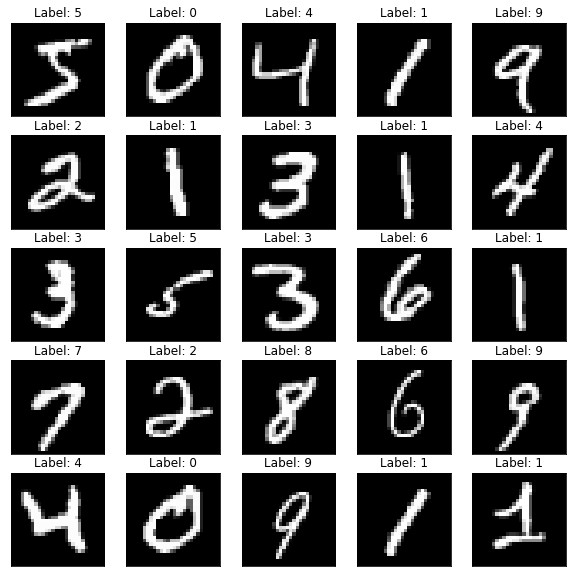

In [3]:
#display sample images from the dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title("Label: {}".format(y_train[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [4]:
#add gausian noise to dataset
noise_factor = 0.5
x_train_noisy = x_train_expanded + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_expanded.shape) 
x_test_noisy = x_test_expanded + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_expanded.shape) 

#clip the data so that the pixel values are between 0 and 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

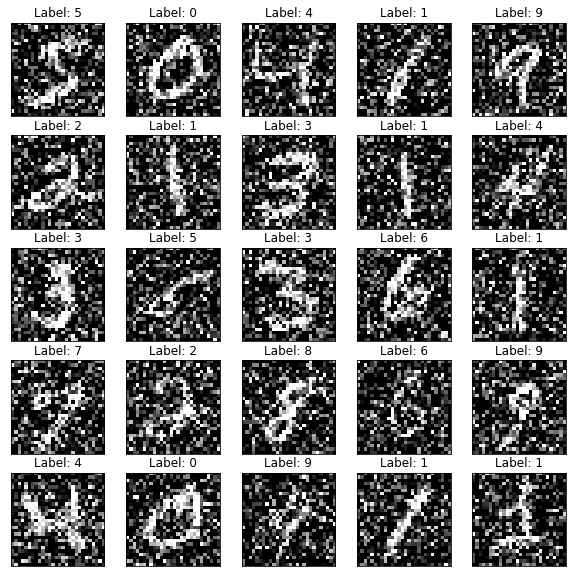

In [5]:
#display the sample noisy images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(x_train_noisy[i, :, :, 0], cmap='gray')
    plt.title("Label: {}".format(y_train[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [6]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.models import Model

def encoder(input_img):
    """
    Encoder function.
    Arguments:
      input_img: Input image, Tensor of shape (28, 28, 1)
    
    Returns: Encoded image, Tensor of shape (7, 7, 8)
    """
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='encoder_conv1')(input_img)
    x = MaxPool2D((2, 2), padding='same', name='encoder_pool1')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name='encoder_conv2')(x)
    x = MaxPool2D((2, 2), padding='same', name='encoder_pool2')(x)
    encoded = Conv2D(8, (3, 3), activation='relu', padding='same', name='encoder_conv3')(x)
    return encoded


def decoder(encoded):
    """
    Decoder function.
    Arguments:
      encoded: Encoded image, Tensor of shape (7, 7, 8)
    
    Returns: Decoded images, Tensor of shape (28, 28, 1)
    """
    x = Conv2D(8, (3, 3), activation='relu', padding='same', name='decoder_conv1')(encoded)
    x = UpSampling2D((2, 2), name='decoder_upsample1')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name='decoder_conv2')(x)
    x = UpSampling2D((2, 2), name='decoder_upsample2')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='decoder_conv3')(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='decoder_conv4')(x)
    return decoded

In [8]:
#create input tensor
input_img = Input(shape=(28, 28, 1))

#create autoencoder model
autoencoder = Model(input_img, decoder(encoder(input_img)))
#complile model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

#show model structure
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_conv1 (Conv2D)       (None, 28, 28, 32)        320       
_________________________________________________________________
encoder_pool1 (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
encoder_conv2 (Conv2D)       (None, 14, 14, 16)        4624      
_________________________________________________________________
encoder_pool2 (MaxPooling2D) (None, 7, 7, 16)          0         
_________________________________________________________________
encoder_conv3 (Conv2D)       (None, 7, 7, 8)           1160      
_________________________________________________________________
decoder_conv1 (Conv2D)       (None, 7, 7, 8)           584   

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#define callback for earlystopping to stop training if the validation loss does not decrese for 10 epochs 
earlyStopping = EarlyStopping(monitor='val_loss', patience=10)

#define callback to save model weights if the validation loss improves
modelChkpt = ModelCheckpoint(filepath='best_weights.h5', monitor='val_loss', save_best_only=True) 

#train model
train_history = autoencoder.fit(x_train_noisy, x_train_expanded,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test_expanded),
                callbacks=[modelChkpt, earlyStopping]
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 28s 474us/sample - loss: 0.1813 - val_loss: 0.1237
Epoch 2/100
60000/60000 [==============================] - 24s 397us/sample - loss: 0.1179 - val_loss: 0.1123
Epoch 3/100
60000/60000 [==============================] - 37s 625us/sample - loss: 0.1110 - val_loss: 0.1079
Epoch 4/100
60000/60000 [==============================] - 40s 665us/sample - loss: 0.1078 - val_loss: 0.1056
Epoch 5/100
60000/60000 [==============================] - 39s 655us/sample - loss: 0.1060 - val_loss: 0.1043
Epoch 6/100
60000/60000 [==============================] - 39s 653us/sample - loss: 0.1045 - val_loss: 0.1034
Epoch 7/100
60000/60000 [==============================] - 39s 654us/sample - loss: 0.1035 - val_loss: 0.1021
Epoch 8/100
60000/60000 [==============================] - 55s 912us/sample - loss: 0.1027 - val_loss: 0.1018
Epoch 9/100
60000/60000 [==============================] - 80s 1ms/sam

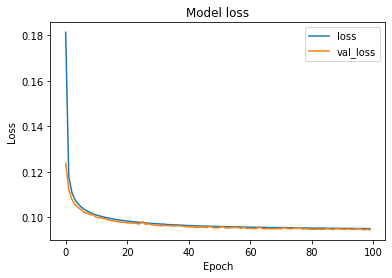

In [10]:
#plot training and validation loss for model
plt.plot(train_history.history['loss'], label='loss')
plt.plot(train_history.history['val_loss'], label='val_loss')
plt.title("Model loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

We see a smooth curve for both train and validation loss and the model converges to a loss of 0.0945.

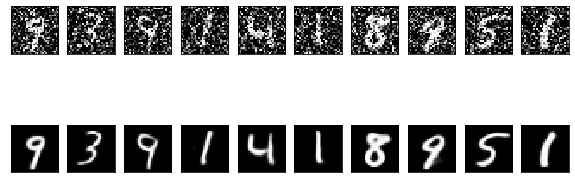

In [11]:
#Display a random noisy test images and corresponding denoised images predicted by our model
n = 10 #number of random images to display
plt.figure(figsize=(10, 4))

for i in range(n):
    test_size = len(x_test_noisy)
    index = np.random.randint(0, test_size)
    test_image = np.expand_dims(x_test_noisy[index], axis=0)
    test_output = autoencoder.predict(test_image)
    plt.subplot(2, n, i+1)
    plt.imshow(x_test_noisy[index, :, :, 0], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(2, n, n+i+1)
    plt.imshow(test_output[0, :, :, 0], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

Above sample test predictions show that images are denoised correctly.